<a href="https://colab.research.google.com/github/audalsgh/20250715/blob/main/0715_CNN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 1. ReLU (Rectified Linear Unit) : 입력이 0 이하면 0으로 출력, 0 이상일 때는 입력값 그대로 출력
 -> 계산이 매우 단순하여 학습 속도가 빠름<br>
2. Softmax : 3개의 정답 라벨에 대응되는 출력값을 총합이 1이되는 확률분포로 볼수있게함.

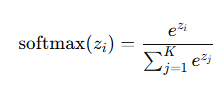<br>
-> 다중 클래스 분류의 출력층에서 각 클래스에 대한 확률 분포를 만들어 줌
3. Dropout(0.5) : 신경망이 학습할 때 **절반(50%)**의 뉴런을 랜덤하게 꺼서(drop) 과적합(overfitting) 방지
-> 평가,추론 단계에선 모든 뉴런을 써야함. 학습할때만 드롭아웃을 적용하는것.
4. Dense(units, activation='relu') : 해당 레이어가 가지는 뉴런(출력 노드)의 개수, 적용시킬 활성화 함수는 'relu' 선택
-> 정답 클래스 3개에 대한 출력 클래스에 softmax를 적용한 확률분포를 보고 정답 판단<br>
-> 컨볼루션 레이어는 특징맵을 추출하고, Dense 레이어가 그걸 기반으로 분류(classification)하는 역할을 합니다.

In [1]:
# 📘 진짜 CNN 교육용 데모 - Google Colab용
# 사진 하나 업로드로 CNN 체험하기!

# 🔧 필요한 라이브러리 설치
!pip install tensorflow matplotlib pillow numpy  # 딥러닝 모델 생성·학습용, 결과 시각화용, Python 이미지 처리, 수치 연산 및 배열 처리

# 📦 라이브러리 임포트
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image  #Pillow의 이미지 클래스
import io  #메모리-바이트 스트림 처리

# 🧠 간단한 CNN 모델 생성
def create_simple_cnn():
    """
    교육용 간단한 CNN 모델 생성
    """
    model = tf.keras.Sequential([
        # 컨볼루션마다 16, 32, 64 = 총 112개의 필터가 사용중, 그러나 출력엔 일부 8개의 필터만 보이도록했다.
        # 필터 갯수가 많을수록 디테일한 수준의 특징을 학습 (눈,귀 등)
        # 첫 컨볼루션이 제일 오래걸린다. (선인지, 면인지 구분)

        # 첫 번째 컨볼루션 레이어
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),  #16개의 (3×3) 필터, 입력 이미지(64×64×3)에서 컨볼루션, 렐루적용 후
        tf.keras.layers.MaxPooling2D(2, 2),  # (2×2)크기를 훑으며, 그 중 최댓값만 남겨서 출력 크기를 절반으로 축소 = 풀링

        # 두 번째 컨볼루션 레이어
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # 세 번째 컨볼루션 레이어
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # 분류기 Flatten & Dense 레이어
        tf.keras.layers.Flatten(),  # 다차원 특징 맵을 1차원 벡터로 평탄화
        tf.keras.layers.Dense(128, activation='relu'),  # 128개의 완전연결 층, 렐루적용 후,
        tf.keras.layers.Dropout(0.5),  # 과적합을 막기위해 50%만 랜덤하게 쓸것.
        tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: Animal/Car/Other, 각 클래스의 확률분포 합이 1이 되도록 정규화
    ])

    # 모델 컴파일, 학습할 모델 파라미터 설정
    model.compile(
        optimizer='adam',  # Optimizer: Adam, 모델의 가중치(파라미터)를 자동 업데이트하는 알고리즘
        loss='categorical_crossentropy',  # Loss Function: Categorical Crossentropy, 다중 클래스 분류에 표준으로 쓰이는 손실 함수
        metrics=['accuracy']  # 학습 중·후에 모델 성능을 “얼마나 맞췄는지” 평가
    )

    print("🧠 CNN 모델 생성 완료!")
    return model

In [13]:
# 📊 CNN 구조 시각화
def visualize_model_architecture(model):
    """
    CNN 모델 구조를 시각적으로 보여주기
    """
    print("\n📋 CNN 모델 구조:")
    print("=" * 50)
    model.summary()  # 케라스(Keras) 모델의 구조를 콘솔(터미널)상에 표로 요약해서 출력해줌.

    # 레이어별 설명
    print("\n🔍 레이어별 역할:")
    print("📌 Conv2D: 특징 추출 (엣지, 패턴 등)")
    print("📌 MaxPooling2D: 크기 축소 + 중요 특징 선택")
    print("📌 Flatten: 2D → 1D 변환")
    print("📌 Dense: 최종 분류 결정")
    print("📌 Dropout: 과적합 방지")

In [3]:
# 🔍 CNN 필터 시각화
def visualize_cnn_filters(model):
    """
    CNN 첫 번째 레이어의 학습된 필터들 시각화
    """
    try:
        # 모델 빌드가 안됬다면, 더미 입력을 한번 순전파시켜서 내부 레이어를 모두 초기화.
        if not hasattr(model, 'built') or not model.built:
            print("⚠️ 모델을 빌드하는 중...")
            dummy_input = np.random.rand(1, 64, 64, 3)
            _ = model(dummy_input)

        # model.layers를 순회하며 Conv2D 타입인 첫 레이어를 찾아냄.
        first_conv_layer = None
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                first_conv_layer = layer
                break

        if first_conv_layer is None:
            print("❌ Conv2D 레이어를 찾을 수 없습니다.")
            return

        # 첫 번째 Conv2D 레이어의 가중치 추출
        # get_weights()로 [kernel, bias] 리스트를 받아옴.
        # weights[0]이 바로 (height, width, in_channels, out_channels) 형태의 필터 가중치가 담긴 텐서
        # (필터크기, RGB채널수, 출력수)
        weights = first_conv_layer.get_weights()
        if len(weights) == 0:
            print("⚠️ 아직 가중치가 초기화되지 않았습니다.")
            return

        filters = weights[0]  # 필터 가중치

        print(f"\n🔍 첫 번째 레이어 필터 시각화")
        print(f"필터 개수: {filters.shape[3]}개")
        print(f"필터 크기: {filters.shape[0]}x{filters.shape[1]}")  # filters.shape[0], filters.shape[1]: 필터의 공간 크기

        # 필터 중 처음 8개만 시각화
        num_filters_to_show = min(8, filters.shape[3])
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        fig.suptitle('CNN Learned Filters (First Layer)', fontsize=16)

        for i in range(num_filters_to_show):
            ax = axes[i // 4, i % 4]

            # 필터를 시각화하기 위해 정규화
            filter_img = filters[:, :, 0, i]  # (필터크기, R채널, i번째 출력만 선택)

            # (0-1 범위로)정규화한뒤, 색상 맵(viridis)으로 렌더링
            if filter_img.max() > filter_img.min():
                filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())

            ax.imshow(filter_img, cmap='viridis')
            ax.set_title(f'Filter {i+1}')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ 필터 시각화 중 오류 발생: {str(e)}")
        print("💡 이는 모델 구조나 가중치 이슈일 수 있습니다.")
        print("📝 주요 기능(예측)은 정상 작동합니다!")

In [4]:
# 📸 이미지 업로드 및 전처리
def upload_and_preprocess_image():
    """
    이미지 업로드 및 CNN 입력용 전처리
    """
    print("📸 이미지를 업로드해주세요!")
    uploaded = files.upload()

    filename = list(uploaded.keys())[0]  # 업로드된 파일이 하나라고 가정하고, 딕셔너리의 첫 번째 키를 꺼냄
    image_data = uploaded[filename]  # 그 파일명에 대응하는 바이너리 데이터(=이미지)를 image_data에 저장

    # 이미지 로드 및 전처리
    # io.BytesIO로 바이트 데이터를 메모리 스트림처럼 래핑(wrapper)
    # PIL.Image.open()에 넘겨 실제 Image 객체
    image = Image.open(io.BytesIO(image_data))

    # RGB로 변환 (RGBA인 경우가 있을수 있다)
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # 크기 조정 (64x64)
    image_resized = image.resize((64, 64))

    # 배열로 변환 및 float32 타입으로 캐스팅하고 픽셀 값(0–255)을 (0.0 – 1.0)범위로 정규화
    image_array = np.array(image_resized).astype('float32') / 255.0

    # 배치 차원 추가 (1, 64, 64, 3)
    # 하나의 이미지를 shape=(1, 64, 64, 3) 형태로 만듬
    image_batch = np.expand_dims(image_array, axis=0)

    # 원본, 리사이즈된 이미지, 배치용 배열, 파일명 반환
    return image, image_resized, image_batch, filename  # CNN입력에 쓸 객체는 image_batch

In [5]:
# 🎯 CNN 예측 및 결과 시각화
def predict_and_visualize(model, original_img, processed_img, image_batch, filename):
    """
    CNN으로 예측하고 결과 시각화
    """
    # 클래스 라벨 정의
    class_names = ['Animal', 'Car', 'Other']

    # CNN 예측
    predictions = model.predict(image_batch, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    # 결과 시각화
    plt.figure(figsize=(15, 5))

    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title(f'original image\n({filename})')
    plt.axis('off')

    # 전처리된 이미지 (CNN 입력)
    plt.subplot(1, 3, 2)
    plt.imshow(processed_img)
    plt.title('CNN input image\n(64x64 size modify)')
    plt.axis('off')

    # 예측 결과
    plt.subplot(1, 3, 3)
    bars = plt.bar(class_names, predictions[0])
    bars[predicted_class].set_color('red')  # 최고 확률 클래스 강조
    plt.title(f'CNN Prediction Results\nPrediction: {class_names[predicted_class]} ({confidence:.2%})')
    plt.ylabel('Probability')
    plt.ylim(0, 1)

    # 확률 값 표시
    for i, (name, prob) in enumerate(zip(class_names, predictions[0])):
        plt.text(i, prob + 0.02, f'{prob:.2%}', ha='center')

    plt.tight_layout()
    plt.show()

    # 결과 출력
    print("\n🎯 CNN Prediction Results:")
    print("=" * 30)
    for i, (name, prob) in enumerate(zip(class_names, predictions[0])):
        marker = "👉" if i == predicted_class else "  "
        print(f"{marker} {name}: {prob:.2%}")
    print("=" * 30)
    print(f"Final Prediction: {class_names[predicted_class]} (Confidence: {confidence:.2%})")

In [6]:
# 🔬 CNN 중간 레이어 활성화 시각화
def visualize_intermediate_activations(model, image_batch):
    """
    CNN 중간 레이어들의 활성화 맵 시각화
    """
    print("\n🔬 CNN 내부 작동 과정 시각화...")

    try:
        # 모델이 빌드되었는지 확인
        if not hasattr(model, 'built') or not model.built:
            print("⚠️ 모델을 빌드하는 중...")
            # 더미 데이터로 모델 빌드
            dummy_input = np.random.rand(1, 64, 64, 3)
            _ = model(dummy_input)

        # Conv2D 레이어만 찾기
        conv_layers = []
        layer_names = []

        for i, layer in enumerate(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                conv_layers.append(layer)
                layer_names.append(f'Conv2D Layer {len(conv_layers)}')

        if len(conv_layers) == 0:
            print("❌ Conv2D 레이어를 찾을 수 없습니다.")
            return

        # 중간 레이어 출력을 위한 모델 생성
        layer_outputs = [layer.output for layer in conv_layers]
        activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

        # 활성화 맵 계산
        activations = activation_model.predict(image_batch, verbose=0)

        # 단일 출력인 경우 리스트로 변환
        if not isinstance(activations, list):
            activations = [activations]

        # 시각화
        num_layers = min(3, len(conv_layers))  # 최대 3개 레이어만
        plt.figure(figsize=(15, 10))

        for i in range(num_layers):
            activation = activations[i]
            layer_name = layer_names[i]

            # 처음 4개 필터만 표시
            num_filters = min(4, activation.shape[-1])
            for j in range(num_filters):
                plt.subplot(num_layers, 4, i*4 + j + 1)

                # 활성화 맵 정규화
                feature_map = activation[0, :, :, j]
                if feature_map.max() > feature_map.min():
                    feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

                plt.imshow(feature_map, cmap='viridis')
                plt.title(f'{layer_name}\nFilter {j+1}')
                plt.axis('off')

        plt.suptitle('CNN Feature Maps - How CNN "Sees" Your Image', fontsize=16)
        plt.tight_layout()
        plt.show()

        print("💡 해석:")
        print("- 첫 번째 레이어: 기본적인 엣지, 색상 검출")
        print("- 두 번째 레이어: 더 복잡한 패턴 조합")
        print("- 세 번째 레이어: 고수준 특징 (객체 부분)")

    except Exception as e:
        print(f"⚠️ 활성화 시각화 중 오류 발생: {str(e)}")
        print("💡 이는 모델 구조나 TensorFlow 버전 이슈일 수 있습니다.")
        print("📝 주요 기능(예측)은 정상 작동합니다!")

📚 CNN 교육용 데모 - 실제 신경망으로 이미지 분류 체험
🔥 이번에는 진짜 CNN입니다!

🎉 진짜 CNN 교육용 데모 시작!
🧠 CNN 모델 생성 완료!

📋 CNN 모델 구조:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,011 (1.22 MB)

 Trainable params: 319,011 (1.22 MB)

 Non-trainable params: 0 (0.00 B)


🔍 레이어별 역할:
📌 Conv2D: 특징 추출 (엣지, 패턴 등)
📌 MaxPooling2D: 크기 축소 + 중요 특징 선택
📌 Flatten: 2D → 1D 변환
📌 Dense: 최종 분류 결정
📌 Dropout: 과적합 방지

🎓 데모용 빠른 훈련 시작...
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.2559 - loss: 1.1689
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4292 - loss: 1.0964 
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3359 - loss: 1.0952
✅ 훈련 완료! (실제 프로젝트에서는 실제 데이터 사용)

🔍 첫 번째 레이어 필터 시각화
필터 개수: 16개
필터 크기: 3x3


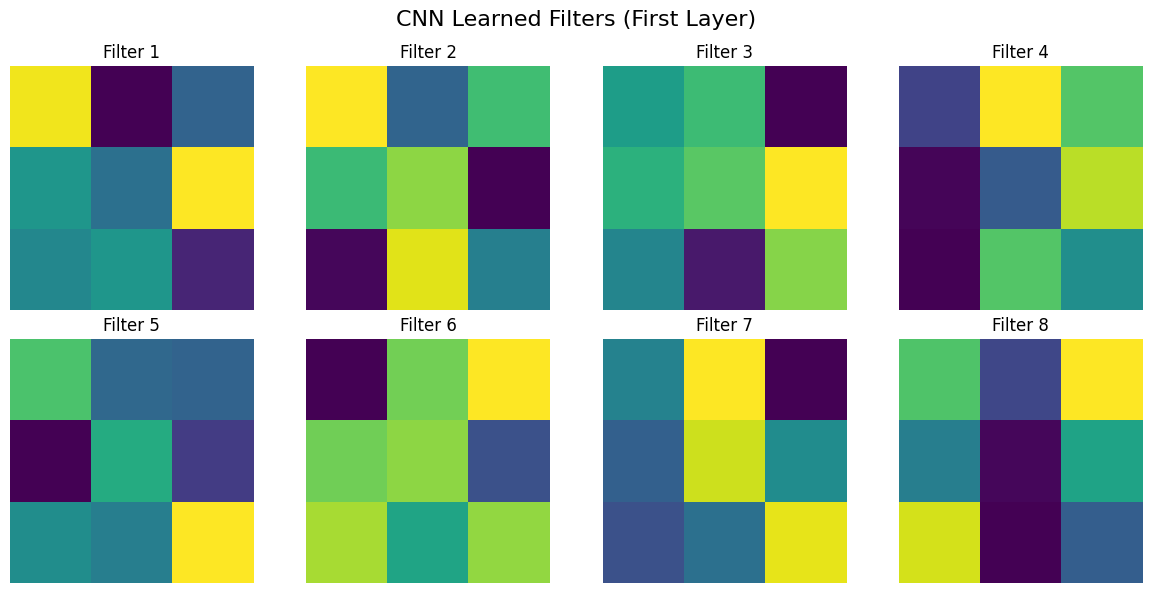

📸 이미지를 업로드해주세요!


Saving 증사.jpg to 증사 (1).jpg


/tmp/ipython-input-5-909547488.py:41: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-5-909547488.py:41: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-5-909547488.py:41: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-5-909547488.py:41: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-5-909547488.py:41: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-5-909547488.py:41: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


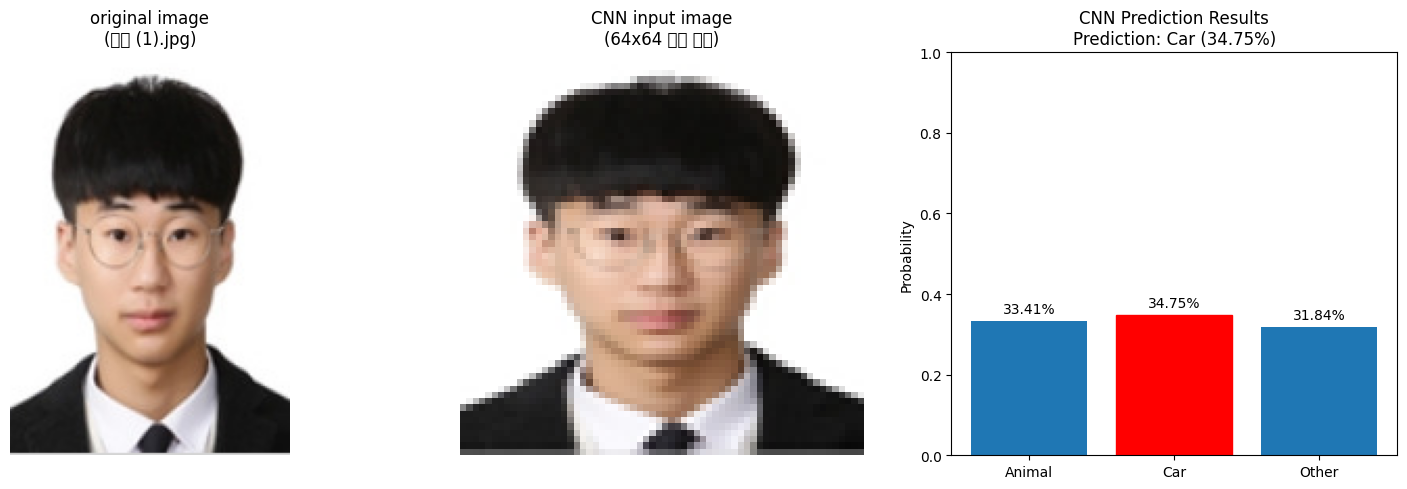


🎯 CNN Prediction Results:
   Animal: 33.41%
👉 Car: 34.75%
   Other: 31.84%
Final Prediction: Car (Confidence: 34.75%)

🔬 CNN 내부 작동 과정 시각화...
⚠️ 활성화 시각화 중 오류 발생: The layer sequential_2 has never been called and thus has no defined input.
💡 이는 모델 구조나 TensorFlow 버전 이슈일 수 있습니다.
📝 주요 기능(예측)은 정상 작동합니다!

🎓 CNN 데모 완료!
💡 이제 CNN이 어떻게 이미지를 '이해'하는지 보셨습니다!


In [10]:
# 🎮 메인 실행 함수
def run_cnn_demo():
    """
    CNN 교육용 데모 메인 실행
    """
    print("🎉 CNN 교육용 데모 시작!")
    print("=" * 50)

    # 1. CNN 모델 생성
    model = create_simple_cnn()

    # 2. 모델 구조 확인
    visualize_model_architecture(model)

    # 3. 학습된 필터 시각화
    visualize_cnn_filters(model)

    # 4. 이미지 업로드 및 예측
    original_img, processed_img, image_batch, filename = upload_and_preprocess_image()

    # 5. CNN 예측 및 결과 시각화
    predict_and_visualize(model, original_img, processed_img, image_batch, filename)

    # 6. CNN 내부 작동 과정 시각화
    visualize_intermediate_activations(model, image_batch)

    print("\n🎓 CNN 데모 완료!")
    print("💡 이제 CNN이 어떻게 이미지를 '이해'하는지 보셨습니다!")

# 🚀 데모 실행
print("📚 CNN 교육용 데모 - 실제 신경망으로 이미지 분류 체험")
print()
run_cnn_demo()

In [12]:
# 기본 사용 예시
from PIL import Image, ImageFilter, ImageDraw

# 이미지 열기
img = Image.open('/content/증사.jpg')

# 기본 정보 확인
print(f"크기: {img.size}")
print(f"모드: {img.mode}")
print(f"형식: {img.format}")

# 크기 조정
resized = img.resize((800, 600))
# 회전
rotated = img.rotate(45)
# 필터 적용
blurred = img.filter(ImageFilter.BLUR)

# 저장
img.save('output.png')

크기: (134, 193)
모드: RGB
형식: JPEG
